### Equivalent demand reduction

In [1]:
import numpy as np
import pickle
import wntr
import copy

In [2]:
import matplotlib
import matplotlib.pyplot as plt
# "the default sans-serif font is Arial"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
#matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14})

In [3]:
Wdn = wntr.network.WaterNetworkModel(r'CoH_Backbone_Final.inp')

C:\Users\xz68\Anaconda3\lib\site-packages\wntr\epanet\io.py:2192: UserWarning: Not all curves were used in "CoH_Backbone_Final.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


In [4]:
# Xwu = np.array([4.80382,2.15906,11.40229])
DPRlist = ['UB', 'KB', 'BW', 'NW', 'WD', 'AS', 'SW', 'TC', 'WO', 'IAH']
Xu = np.array([0.33114048327575885,
 0.43659751501715094,
 0.24810770502017204,
 0.4421810641194354,
 0.5349400246169953,
 0.5823551632101737,
 1.2954734429779715,
 0.257563715556331,
 0.08105151888136293,
 0.07416213977644706])
# The amortization parameter to transfer the total cost to annual cost
Amortization = 0.074549

In [5]:
Tgc = [0.10094432,
 0.648567295,
 0.11547529999999999,
 0,
 0.39115924,
 0.12618041,
 0.1892706,
 0.22081569,
 0,
 0.12618041]

In [6]:
DPRBN = {'UB':['357', '237'], 'BW':['2015', '2005', '237'], 'NW': ['503', '3495', '3494'], 'WD':['3913'], 'AS':['21', '1133', '369'],
        'SW':['1317', '3920', '1692'], 'TC':['3913'], 'WO':['500'] }
BNdemand = {'357':0.2824, '237':0.2831, '2015':0.0025, '2005':0.0049, '503':0.0041, '3495':0.3072, '3494':0.2999, '3913': 0.3813,
            '21':0.0222, '1133':0.0259, '369': 0.0536, '1317':0.3177, '3920':0.3352, '1692':0.0436, '500':0.13886}

In [7]:
def hydraulic_energy(ei, wdn, x0, x1, x2, x3, x4, x5, x6, x7, x8, x9):
    wdnsample = copy.deepcopy(wdn)
    saving_gwtp = 0
    consump_distr = 0
    # x0: 'UB'
    if x0 <= 0.1009:
        saving_gwtp += (1-ei)*x0
    elif 0.1009 < x0 <= 0.3833:
        saving_gwtp += (1-ei)*0.1009
        node01 = wdnsample.get_node('357')
        node01demand = node01.demand_timeseries_list[0].base_value
        # The 1.15 factor is the demand pattern factor
        node01.demand_timeseries_list[0].base_value = node01demand - 1.15*(x0-0.1009)
    elif 0.3833 < x0:
        saving_gwtp += (1-ei)*0.1009
        node01 = wdnsample.get_node('357')
        node01.demand_timeseries_list[0].base_value = 1e-5
        node02 = wdnsample.get_node('237')
        node02demand = node02.demand_timeseries_list[0].base_value
        node02.demand_timeseries_list[0].base_value = node02demand - 1.15*(x0-0.3833)
    
    # x1: 'KB', its capacity is less than the GWTP demand
    saving_gwtp += (1-ei)*x1
    
    # x2: 'BW'
    if x2 <= 0.1155:
        saving_gwtp += (1-ei)*x2
    elif 0.1155 < x2 <= 0.1180:
        saving_gwtp += (1-ei)*0.1155
        node21 = wdnsample.get_node('2015')
        node21demand = node21.demand_timeseries_list[0].base_value
        node21.demand_timeseries_list[0].base_value = node21demand - 1.15*(x2-0.1155)    
    elif 0.1180 < x2 <= 0.1229:
        saving_gwtp += (1-ei)*0.1155
        node21 = wdnsample.get_node('357')
        node21.demand_timeseries_list[0].base_value = 1e-5
        node22 = wdnsample.get_node('2005')
        node22demand = node21.demand_timeseries_list[0].base_value
        node22.demand_timeseries_list[0].base_value = node22demand - 1.15*(x2-0.1180)  
    # The '237' node need more supply
    elif 0.1229 < x2:
        saving_gwtp += (1-ei)*0.1155
        node21 = wdnsample.get_node('357')
        node21.demand_timeseries_list[0].base_value = 1e-5
        node22 = wdnsample.get_node('2005')
        node22.demand_timeseries_list[0].base_value = 1e-5
        node23 = wdnsample.get_node('237')
        node23demand = node23.demand_timeseries_list[0].base_value
        node23.demand_timeseries_list[0].base_value = node23demand - 1.15*(x2-0.1229)
    
    # x3:'NW', only supply to the main system
    if x3 <= 0.0041:
        node31 = wdnsample.get_node('503')
        node31.demand_timeseries_list[0].base_value -= 1.15*x3 
        
    elif 0.0041 < x3 <= 0.3112:
        node31 = wdnsample.get_node('503')
        node31.demand_timeseries_list[0].base_value = 1e-5
        node32 = wdnsample.get_node('3495')
        node32.demand_timeseries_list[0].base_value -= 1.15*(x3-0.0041)
    # The '3494' node needs more supply
    elif 0.3112 < x3:
        node31 = wdnsample.get_node('503')
        node31.demand_timeseries_list[0].base_value = 1e-5
        node32 = wdnsample.get_node('3495')
        node32.demand_timeseries_list[0].base_value = 1e-5
        node33 = wdnsample.get_node('3494')
        node33.demand_timeseries_list[0].base_value -= 1.15*(x3-0.3112)
    
    # x4: 'WD'
    if x4 <= 0.3911:
        saving_gwtp += (1-ei)*x4
    elif 0.3911 < x4:
        saving_gwtp += (1-ei)*0.3911
        node41 = wdnsample.get_node('3913')
        node41.demand_timeseries_list[0].base_value -= 1.15*(x4-0.3911)
    
    # x5: 'AS'
    if x5 <= 0.1262:
        saving_gwtp +=  (1-ei)*x5
    elif 0.1262 < x5 <= 0.1484:
        saving_gwtp += (1-ei)*0.1262
        node51 = wdnsample.get_node('21')
        node51.demand_timeseries_list[0].base_value -= 1.15*(x5-0.1262)
    elif 0.1484 < x5 <= 0.1743:
        saving_gwtp += (1-ei)*0.1262
        node51 = wdnsample.get_node('21')
        node51.demand_timeseries_list[0].base_value = 1e-5
        node52 = wdnsample.get_node('1133')
        node52.demand_timeseries_list[0].base_value -= 1.15*(x5-0.1484)
    elif 0.1743 < x5 <= 0.2279:
        saving_gwtp += (1-ei)*0.1262
        node51 = wdnsample.get_node('21')
        node51.demand_timeseries_list[0].base_value = 1e-5
        node52 = wdnsample.get_node('1133')
        node52.demand_timeseries_list[0].base_value = 1e-5
        node53 = wdnsample.get_node('369')
        node53.demand_timeseries_list[0].base_value -= 1.15*(x5-0.1743)
    # There will not be further saving
    else:
        saving_gwtp += (1-ei)*0.1262
        node51 = wdnsample.get_node('21')
        node51.demand_timeseries_list[0].base_value = 1e-5
        node52 = wdnsample.get_node('1133')
        node52.demand_timeseries_list[0].base_value = 1e-5
        node53 = wdnsample.get_node('369')
        node53.demand_timeseries_list[0].base_value = 1e-5
    
    # x6: 'SW'
    if x6 <= 0.1893:
        saving_gwtp += (1-ei)*x6
    elif 0.1893 < x6 <= 0.507:
        saving_gwtp += (1-ei)*0.1893
        node61 = wdnsample.get_node('1317')
        node61.demand_timeseries_list[0].base_value -= 1.15*(x6-0.1893)
    elif 0.507 < x6 <= 0.8422:
        saving_gwtp += (1-ei)*0.1893
        node61 = wdnsample.get_node('1317')
        node61.demand_timeseries_list[0].base_value = 1e-5
        node62 = wdnsample.get_node('3920')
        node62.demand_timeseries_list[0].base_value -= 1.15*(x6-0.507)
    elif 0.8422 < x6 <= 0.8858:
        saving_gwtp += (1-ei)*0.1893
        node61 = wdnsample.get_node('1317')
        node61.demand_timeseries_list[0].base_value = 1e-5
        node62 = wdnsample.get_node('3920')
        node62.demand_timeseries_list[0].base_value = 1e-5
        node63 = wdnsample.get_node('1692')
        node63.demand_timeseries_list[0].base_value -= 1.15*(x6-0.8422)
    # There will not be further saving
    else:
        saving_gwtp += (1-ei)*0.1893
        node61 = wdnsample.get_node('1317')
        node61.demand_timeseries_list[0].base_value = 1e-5
        node62 = wdnsample.get_node('3920')
        node62.demand_timeseries_list[0].base_value = 1e-5
        node63 = wdnsample.get_node('1692')
        node63.demand_timeseries_list[0].base_value = 1e-5
    
    # x7:'TC'
    if x7 <= 0.2208:
        saving_gwtp += (1-ei)*x7
    # Supply 3913  
    else:
        saving_gwtp += (1-ei)*0.2208
        node63 = wdnsample.get_node('3913')
        node63.demand_timeseries_list[0].base_value -= 1.15*(x7-0.2208)    
    
    # x8: 'WO' only supply to the main system
    node81 = wdnsample.get_node('500')
    node81.demand_timeseries_list[0].base_value -= 1.15*x8 
    
    # x9: 'IAH' its capacity is less than the GWTP demand 
    saving_gwtp +=  (1-ei)*x9
    try:
        wdnsample.options.time.duration = 2 * 3600
        simsample = wntr.sim.WNTRSimulator(wdnsample)
        results = simsample.run_sim()
        # Caculate the distribution energy consumed by pumps
        pumplist = wdnsample.pump_name_list
        flow = results.link['flowrate']
        head = results.node['head']
        for link in pumplist:
            # The flowrate along it
            q = abs(flow.loc[0*3600, link])
            linkobject = wdnsample.get_link(link)
            sn = linkobject.start_node_name
            en = linkobject.end_node_name
            sh = head.loc[0*3600, sn]
            eh = head.loc[0*3600, en]
            # The energy efficiency is assumed to be 75%, directly transform to kwh
            consump_distr += (abs(sh-eh) * q * 1e4 * 2.7778e-7/0.75)
    except:
        # Give a large penalty for those that can not be run
        consump_distr = 1e4
    total = consump_distr - saving_gwtp
    return total 

### Initialize the problem instance

In [8]:
from pymoo.util.misc import stack
from pymoo.core.problem import ElementwiseProblem

In [9]:
Scalefactor = 18.6815

In [10]:
Xl = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [11]:
# Parameters for the cost estimation
Ac = 18740
Bc = 0.21
Aom = 386.9
Bom = 0.095
Com = 167.3
Ei = 0.8

In [12]:
class MyProblem(ElementwiseProblem):
    def __init__(self):
        # There are two equivalent constraints for the equality constraint 
        super().__init__(n_var=10,
                         n_obj=2,
                         n_constr=0,
                         xl=Xl,
                         xu=Xu)
    def _evaluate(self, x, out, *args, **kwargs):
        # f1 is the daily energy saving in terms of MWh 
        f1 = Scalefactor * hydraulic_energy(Ei, Wdn, x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9]) * (3.6)
        # f2 is the normalized economic cost, unit:million, includes cost for DPR and O&M cost of WTP and GWTP
        f2 = (Amortization*Ac*((x[0]*3600*Scalefactor)**(1-Bc)+ (x[1]*3600*Scalefactor)**(1-Bc)+(x[2]*3600*Scalefactor)**(1-Bc)+ (x[3]*3600*Scalefactor)**(1-Bc)+(x[4]*3600*Scalefactor)**(1-Bc)+(x[5]*3600*Scalefactor)**(1-Bc)+ (x[6]*3600*Scalefactor)**(1-Bc)+(x[7]*3600*Scalefactor)**(1-Bc)+ (x[8]*3600*Scalefactor)**(1-Bc)+(x[9]*3600*Scalefactor)**(1-Bc)) + 
        Aom*((x[0]*3600*Scalefactor)**(1-Bom)+ (x[1]*3600*Scalefactor)**(1-Bom)+(x[2]*3600*Scalefactor)**(1-Bom)+ (x[3]*3600*Scalefactor)**(1-Bom)+(x[4]*3600*Scalefactor)**(1-Bom)+(x[5]*3600*Scalefactor)**(1-Bom)+ (x[6]*3600*Scalefactor)**(1-Bom)+(x[7]*3600*Scalefactor)**(1-Bom)+(x[8]*3600*Scalefactor)**(1-Bom)+(x[9]*3600*Scalefactor)**(1-Bom)) -
             Com*3600*Scalefactor*(x[0]+x[1]+x[2]+x[3]+x[4]+x[5]+x[6]+x[7]+x[8]+x[9]))*1e-6
        
        out["F"] = [f1, f2]

In [13]:
Elementwise_problem = MyProblem()

### Implement the NSGA-II solver

In [14]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation

In [15]:
FXinitialization = open('Xinitialization_0.8.pickle', 'rb')
Xinitialization = pickle.load(FXinitialization)
FXinitialization.close()

In [16]:
Algorithm = NSGA2(pop_size = 1000, n_offsprings = 800, sampling=Xinitialization, crossover=get_crossover("real_sbx", prob=0.9, eta=10),
    mutation=get_mutation("real_pm", eta=20), eliminate_duplicates=True)

#### Define the termination rule

In [17]:
from pymoo.factory import get_termination

In [18]:
Termination = get_termination("n_gen", 500)

#### Optimize

In [19]:
from pymoo.optimize import minimize

In [20]:
Res = minimize(Elementwise_problem, Algorithm, Termination, seed=1, save_history=True, verbose=False)
FRes = open('Res_simplified_0.8_update.pickle', 'wb')
pickle.dump(Res, FRes)
FRes.close()

### Visualize the results

In [30]:
# For the 0.8 scenario
FRes = open('Res_simplified_0.8_update.pickle', 'rb')
Res = pickle.load(FRes)
FRes.close()

In [85]:
# For the 0.4 scenario  Res.F[263, 0],
RepreX = 409.8377 - np.array([Res.F[194, 0], Res.F[905, 0], Res.F[200, 0]])
RepreY = np.array([Res.F[194, 1], Res.F[905, 1], Res.F[200, 1]])

In [93]:
# For the 0.8 scenario 
RepreX = 409.8377 - np.array([Res.F[985, 0], Res.F[990, 0], Res.F[835, 0]])
RepreY = np.array([Res.F[985, 1], Res.F[990, 1], Res.F[835, 1]])

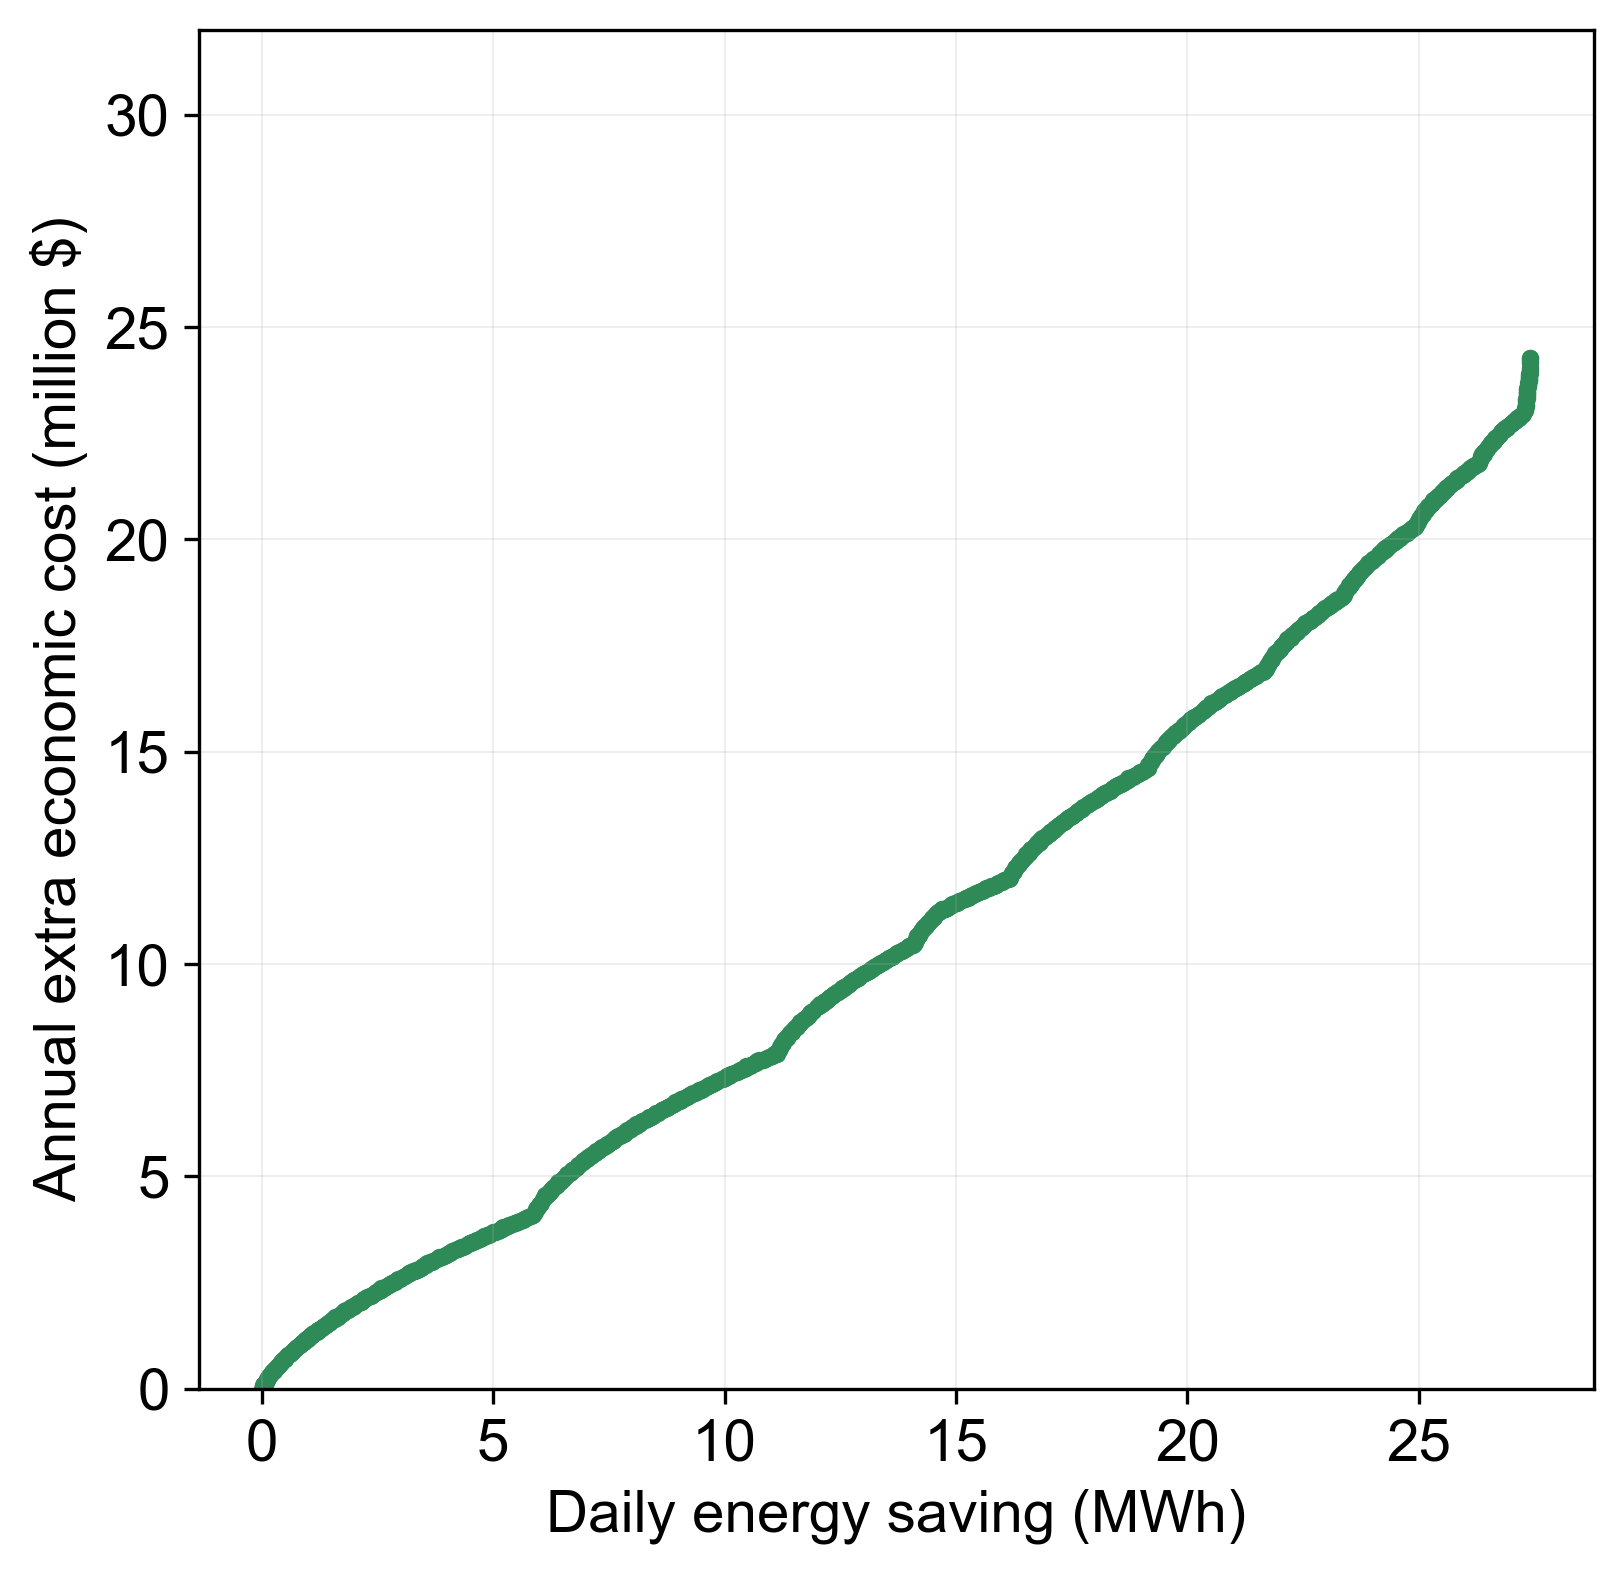

In [24]:
# Transfer back to ennergy saving, the 409.8377 is the baseline energy consumption for distribution in the backbone network
plt.scatter(409.8377-Res.F[:, 0], Res.F[:, 1], s = 10, c = 'seagreen')
# plt.scatter(RepreX, RepreY, marker = "D", s = 40, c = 'coral')
#plt.legend(frameon=False, loc = 'upper left')
plt.grid(linewidth=0.1)
#plt.xlim(0, 1)
plt.ylim(0, 32)
plt.xlabel('Daily energy saving (MWh)')
plt.ylabel('Annual extra economic cost (million $)')
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300
plt.savefig(r"Pareto_front_0.8_update.jpg" , bbox_inches='tight')
plt.show()

In [33]:
np.argmin(abs(Res.F[:, 1]-23))

50

### The specific configuration

In [34]:
# 'UB', 'KB', 'BW', 'NW', 'WD', 'AS', 'SW', 'TC', 'WO', 'IAH'
Res.X[50]

array([0.101, 0.437, 0.116, 0.442, 0.391, 0.127, 0.189, 0.222, 0.001, 0.074])

In [32]:
print(Res.X[7])

[8.688e-07 4.366e-01 3.695e-05 4.421e-01 3.911e-01 1.848e-07 1.823e-02 2.190e-01 2.069e-06 7.557e-07]


In [2]:
print(0.055*(1.055**25)/(1.055**25-1))

0.07454935294643854


In [3]:
[2.082e-02 2.935e+04 8.861e-02 1.864e-03 2.629e+04 2.293e-01 1.089e-02 2.294e+02 3.606e-03 4.857e-02]
[1.467e-02 2.936e+04 2.258e-02 2.973e+04 2.630e+04 4.502e-03 3.071e-02 1.436e+04 1.839e-05 8.305e-04]
[6.822e+03 2.936e+04 7.778e+03 2.974e+04 2.630e+04 8.492e+03 1.275e+04 1.485e+04 2.475e-01 4.987e+03]
[6.833e+03 2.936e+04 8.031e+03 2.973e+04 2.630e+04 1.379e+04 5.819e+04 1.490e+04 1.802e+01 4.974e+03]

0.04


In [22]:
# Calculate the baseline distribution energy consumption
Baseline_consump_distr = 0
Wdn.options.time.duration = 2 * 3600
Sim = wntr.sim.WNTRSimulator(Wdn)
Results = Sim.run_sim()
# Caculate the distribution energy consumed by pumps
Pumplist = Wdn.pump_name_list
Flow = Results.link['flowrate']
Head = Results.node['head']
for link in Pumplist:
    # The flowrate along it
    q = abs(Flow.loc[0*3600, link])
    linkobject = Wdn.get_link(link)
    sn = linkobject.start_node_name
    en = linkobject.end_node_name
    sh = Head.loc[0*3600, sn]
    eh = Head.loc[0*3600, en]
    # The energy efficiency is assumed to be 75%, directly transform to kwh
    Baseline_consump_distr += (abs(sh-eh) * q * 1e4 * 2.7778e-7/0.75)

6.093933199701112

In [23]:
print(Scalefactor *Baseline_consump_distr*3.6)

409.8377270527788


- The first representative scenario:
Active DPRP: 'UB', 'WD', 'IAH'(5%), percent of GWTP: 38.3% <br>
- The second representative scenario:
Active DPRP: 'UB', 'KB', 'WD', 'AS'(6.4%), 'SW'(11.9%), 'TC': (70.5%), 'IAH'
percent of GWTP: 77.3% <br>
- The third representative scenario:
'UB', 'KB', 'NW', 'WD', 'AS'(7.4%), 'SW'(11.2%), 'TC': (70.5%), 'IAH' 

In [ ]:
# Visualize the convergence 
N_evals = []    # corresponding number of function evaluations\
F = []          # the objective space values in each generation
Cv = []         # constraint violation in each generation


# iterate over the deepcopies of algorithms
for Algorithm in Res.history:

    # store the number of function evaluations
    N_evals.append(Algorithm.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    Opt = Algorithm.opt

    # store the least contraint violation in this generation
    Cv.append(Opt.get("CV").min())

    # filter out only the feasible and append
    Feas = np.where(Opt.get("feasible"))[0]
    _F = Opt.get("F")[Feas]
    F.append(_F)

In [ ]:
# MODIFY - this is problem dependend
Ref_point = np.array([0, 1.0])

# create the performance indicator object with reference point
Metric = Hypervolume(ref_point = None, normalize=True, bounds = np.array([[np.min(Res.F[:,0]), np.min(Res.F[:,1])],[np.max(Res.F[:,0]), np.max(Res.F[:,1])]]))

# calculate for each generation the HV metric
HV = [Metric.calc(f) for f in F]

In [ ]:
# visualze the convergence curve
plt.plot(N_evals, HV, '-s', markersize = 3, color = 'cadetblue', linewidth=1)
plt.grid(linewidth=0.2)
# plt.title("Convergence")
#plt.xlim(0, 5e6)
plt.ylim(0, 0.5)
plt.xlabel("Function evaluations")
plt.ylabel("Hypervolume")
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300
plt.savefig(r"Backbone_Convergence_For0.8.jpg" , bbox_inches='tight')
plt.show()